In [1]:
!pip install gcm-filters

  Using cached gcm_filters-0.1.3-py3-none-any.whl (16 kB)


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45743")
client

<Client: 'tcp://127.0.0.1:45743' processes=8 threads=64, memory=235.96 GiB>

In [44]:
client.restart()

<Client: 'tcp://127.0.0.1:34681' processes=1 threads=8, memory=29.50 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import gcm_filters
import s3fs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [6]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [35]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma'
                      ).to_dask()
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso'
                      ).to_dask()
enatl01w

<xarray.Dataset>
Dimensions:        (time_counter: 2136, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: x, y
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

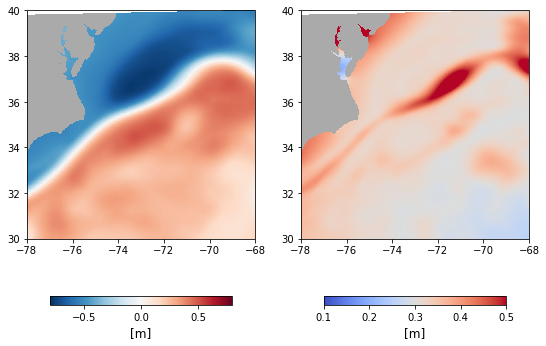

In [7]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(enatl01w.lon, enatl01w.lat,
                     enatl01w.sossheig.mean('time_counter',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )

ax1.pcolormesh(enatl01w.lon, enatl01w.lat, 
               np.ma.masked_values(enatl01w.tmask, 
                                   1.).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(enatl01w.lon, enatl01w.lat,
                     enatl01w.sossheig.std('time_counter',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )

ax2.pcolormesh(enatl01w.lon, enatl01w.lat, 
               np.ma.masked_values(enatl01w.tmask, 
                                   1.).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/eNATL01-SSHmean_fma.pdf')

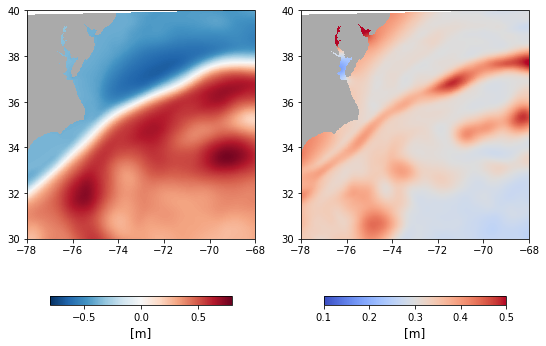

In [6]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(enatl01s.lon, enatl01s.lat,
                     enatl01s.sossheig.mean('time_counter',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )

ax1.pcolormesh(enatl01s.lon, enatl01s.lat, 
               np.ma.masked_values(enatl01s.tmask, 
                                   1.).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(enatl01s.lon, enatl01s.lat,
                     enatl01s.sossheig.std('time_counter',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )

ax2.pcolormesh(enatl01s.lon, enatl01s.lat, 
               np.ma.masked_values(enatl01s.tmask, 
                                   1.).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/eNATL01-SSHmean_aso.pdf')

In [9]:
tenatl = np.arange('2010-02', '2010-05', dtype='datetime64[D]')
tt = np.repeat(tenatl,24)
enatl01w.coords['day'] = ('time_counter', tt)

tenatl = np.arange('2010-08', '2010-11', dtype='datetime64[D]')
tt = np.repeat(tenatl,24)
enatl01s.coords['day'] = ('time_counter', tt)

In [36]:
dxw = xr.DataArray(enatl01w.e1u.data, dims=['y','x'],
#                    coords={'y':np.arange(len(enatl01w.y)),
#                            'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u.data, dims=['y','x'],
#                    coords={'y':np.arange(len(enatl01w.y)),
#                            'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v.data, dims=['y','x'],
#                    coords={'y':np.arange(len(enatl01w.y)),
#                            'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v.data, dims=['y','x'],
#                    coords={'y':np.arange(len(enatl01w.y)),
#                            'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at southern cell edge

dx_min = min(enatl01w.e1u.min(['y','x']), enatl01w.e2u.min(['y','x']),
             enatl01w.e1v.min(['y','x']), enatl01w.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.DataArray(np.zeros_like(enatl01w.sossheig.isel(time_counter=0)),
                        dims=['y','x'],
#                         coords={'y':np.arange(len(enatl01w.y)),
#                                 'x':np.arange(len(enatl01w.x))}
           )
wet_mask[1:-1,1:-1] = enatl01w.tmask[1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask)
kappa_w[1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[1:-1,1:-1] += 1.

area = (enatl01w.e1t * enatl01w.e2t)

filter_50km = gcm_filters.Filter(
    filter_scale=50e3,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)
filter_50km

Filter(filter_scale=50000.0, dx_min=array(1289.18071484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=43, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

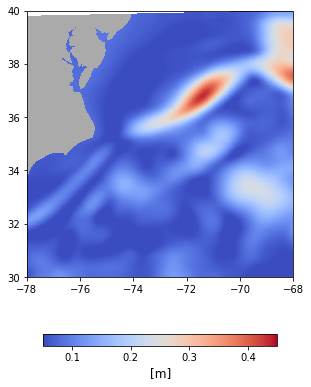

In [37]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())


im1 = ax1.pcolormesh(enatl01w.lon, enatl01w.lat,
#                      enatl01w.sossheig.groupby('day').mean().std('day',skipna=True).data,
#                      enatl01w.sossheig.reset_coords(drop=True).rolling(time_counter=240, center=True
#                                                                       ).mean().std('time_counter',skipna=True
#                                                                                   ).data,
                     filter_50km.apply(enatl01w.sossheig.reset_coords(drop=True).astype(np.float64),
                                        dims=['y', 'x']
                                       ).rolling(time_counter=240, center=True
                                                ).mean().std('time_counter',skipna=True).data,
                     vmin=.05, vmax=.45, cmap='coolwarm', rasterized=True
                    )

ax1.pcolormesh(enatl01w.lon, enatl01w.lat, 
               np.ma.masked_values(enatl01w.tmask, 1.).astype(np.float32),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.6)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/eNATL01-SSH10D-50kmstd_fma.pdf')

In [39]:
hycom01w = cat.HYCOM50(region='1_GS', datatype='surf', season='fma', decode_times=False).to_dask()
hycom01s = cat.HYCOM50(region='1_GS', datatype='surf', season='aso', decode_times=False).to_dask()
hycom50_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()
hycom01w

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503, time: 2160)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2153 2154 2155 2156 2157 2158 2159
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sss        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    vv1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>

In [8]:
mask = ~np.ma.masked_invalid(hycom01w.ssh.isel(time=0)).mask

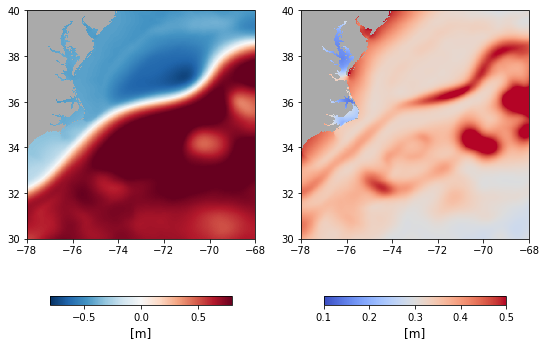

In [10]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(hycom01w.longitude, hycom01w.latitude,
                     hycom01w.ssh.mean('time',skipna=True).data*1e-2,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(hycom01w.longitude, hycom01w.latitude, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(hycom01w.longitude, hycom01w.latitude,
                     hycom01w.ssh.std('time',skipna=True).data*1e-2,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(hycom01w.longitude, hycom01w.latitude, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM01-SSHmean_fma.pdf')

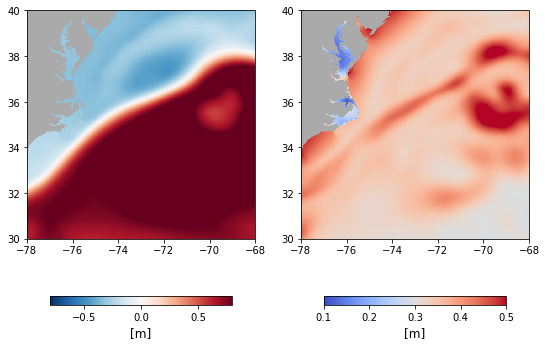

In [9]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(hycom01s.longitude, hycom01s.latitude,
                     hycom01s.ssh.mean('time',skipna=True).data*1e-2,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(hycom01s.longitude, hycom01s.latitude, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(hycom01s.longitude, hycom01s.latitude,
                     hycom01s.ssh.std('time',skipna=True).data*1e-2,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(hycom01s.longitude, hycom01s.latitude, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM01-SSHmean_aso.pdf')

In [40]:
uu1 = hycom01w.uu1
vv1 = hycom01w.vv1
hycom01w = hycom01w.drop('uu1')
hycom01w = hycom01w.drop('vv1')
Ny = len(hycom50_grid.lat)
Nx = len(hycom50_grid.lon)

## Make metadata C-grid again ##

hycom01w['uu1'] = xr.DataArray(uu1.data, dims=['time','lat','lonG'],
                              coords={'time':hycom01w.time,
                                      'lat':hycom01w.lat,'lonG':np.arange(-.5,Nx-.5,1)}
                             )
hycom01w['vv1'] = xr.DataArray(vv1.data, dims=['time','latG','lon'],
                              coords={'time':hycom01w.time,
                                      'latG':np.arange(-.5,Ny-.5,1),'lon':hycom01w.lon}
                             )


coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'}, 
       }

grid = Grid(hycom01w, coords=coords, periodic=[])

import gsw
xx, yy = np.meshgrid(hycom50_grid.longitude, hycom50_grid.latitude)
dxF = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                   coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                  ).interp(lon=hycom01w.lon, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dyF = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                   coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                  ).interp(lat=hycom01w.lat, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dxC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lonG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )
dyC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.latG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dxG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lon, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lat=hycom01w.latG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dyG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.lat, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lon=hycom01w.lonG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )

hycom01w['dxF'] = dxF
hycom01w['dyF'] = dyF
hycom01w['dxC'] = dxC
hycom01w['dyC'] = dyC
hycom01w['dxG'] = dxG
hycom01w['dyG'] = dyG


mask = ~np.ma.masked_invalid(hycom01w.sss.isel(time=0)).mask
wet_mask = xr.DataArray(np.zeros((len(hycom01w.lat),len(hycom01w.lon))),
                        dims=['lat','lon'],
                        coords={'lat':hycom01w.lat,'lon':hycom01w.lon}
           )
wet_mask[1:-1,1:-1] = mask[1:-1,1:-1].astype(np.float64)
wet_mask = wet_mask.chunk({'lat':100,'lon':100})

area = (hycom01w.dxF * hycom01w.dyF)

dxw = xr.DataArray(hycom01w.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(hycom01w.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(hycom01w.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(hycom01w.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge

dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask)

filter_scale = 50e3
filt_mask = wet_mask.chunk({'lat':-1,'lon':-1}).reset_coords(drop=True)

filter_50km = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
            'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
            'area': area.chunk({'lat':-1,'lon':-1}), 
            'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 
            'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
        }
    )

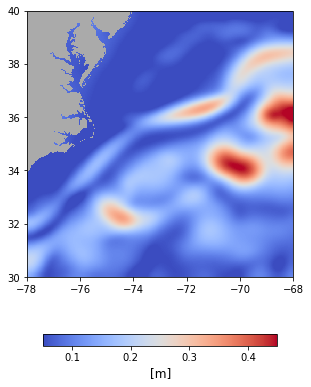

In [41]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())


im1 = ax1.pcolormesh(hycom01w.longitude, hycom01w.latitude,
                     filter_50km.apply(hycom01w.ssh.reset_coords(drop=True).astype(np.float64),
                                       dims=['lat', 'lon']
                                      ).rolling(time=240, center=True
                                               ).mean().std('time',skipna=True).data*1e-2,
                     vmin=.05, vmax=.45, cmap='coolwarm', rasterized=True
                    )
ax1.pcolormesh(hycom01w.longitude, hycom01w.latitude, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.6)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM01-SSH10D-50kmstd_fma.pdf')

In [7]:
hycom25w = cat.HYCOM25(region='1', datatype='surface_hourly', season='fma', decode_times=False).to_dask()
hycom25s = cat.HYCOM25(region='1', datatype='surface_hourly', season='aso', decode_times=False).to_dask()
hycom25w

<xarray.Dataset>
Dimensions:     (X: 250, Y: 305, time: 2136)
Coordinates:
    lat         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
    lon         (Y, X) float32 dask.array<chunksize=(305, 250), meta=np.ndarray>
  * time        (time) int64 0 1 2 3 4 5 6 ... 2130 2131 2132 2133 2134 2135
Dimensions without coordinates: X, Y
Data variables:
    steric_ssh  (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    total_ssh   (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    u_0         (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    u_15        (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    v_0         (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>
    v_15        (time, Y, X) float32 dask.array<chunksize=(356, 305, 250), meta=np.ndarray>

In [7]:
mask = ~np.ma.masked_invalid(hycom25w.total_ssh.isel(time=0)).mask

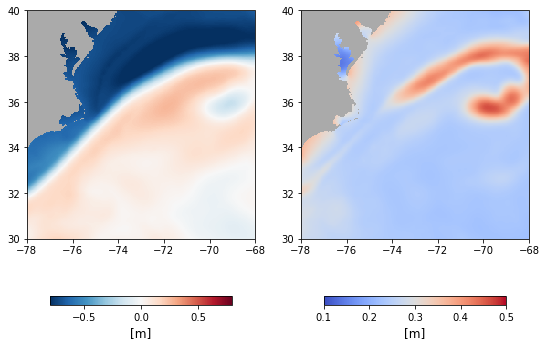

In [10]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(hycom25w.lon, hycom25w.lat,
                     hycom25w.total_ssh.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(hycom25w.lon, hycom25w.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(hycom25w.lon, hycom25w.lat,
                     hycom25w.total_ssh.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(hycom25w.lon, hycom25w.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM25-01-SSHmean_fma.pdf')

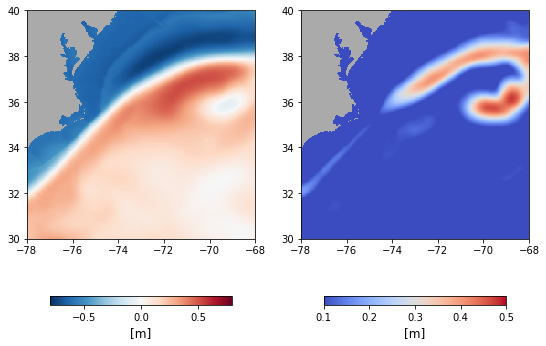

In [12]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(hycom25w.lon, hycom25w.lat,
                     hycom25w.steric_ssh.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(hycom25w.lon, hycom25w.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(hycom25w.lon, hycom25w.lat,
                     hycom25w.steric_ssh.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(hycom25w.lon, hycom25w.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM25-01-stericSSHmean_fma.pdf')

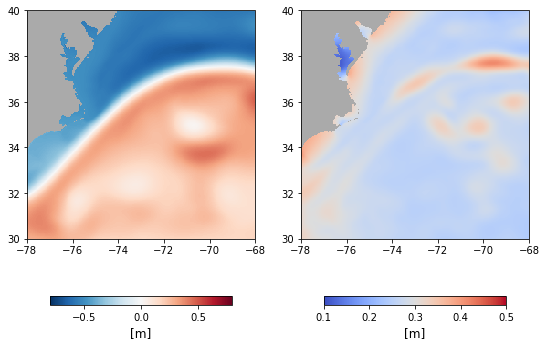

In [11]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(hycom25s.lon, hycom25s.lat,
                     hycom25s.total_ssh.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(hycom25s.lon, hycom25s.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(hycom25s.lon, hycom25s.lat,
                     hycom25s.total_ssh.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(hycom25s.lon, hycom25s.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM25-01-SSHmean_aso.pdf')

In [14]:
u_0 = hycom25w.u_0
u_15 = hycom25w.u_15
v_0 = hycom25w.v_0
v_15 = hycom25w.v_15
hycom25w = hycom25w.drop('u_0')
hycom25w = hycom25w.drop('v_0')
hycom25w = hycom25w.drop('u_15')
hycom25w = hycom25w.drop('v_15')
Ny = len(hycom25w.Y)
Nx = len(hycom25w.X)

## Make metadata C-grid again ##

hycom25w['u_0'] = xr.DataArray(u_0.data, dims=['time','Y','XG'],
                              coords={'time':hycom25w.time,
                                      'Y':hycom25w.Y,'XG':np.arange(-.5,Nx-.5,1)}
                             )
hycom25w['v_0'] = xr.DataArray(v_0.data, dims=['time','YG','X'],
                              coords={'time':hycom25w.time,
                                      'YG':np.arange(-.5,Ny-.5,1),'X':hycom25w.X}
                             )
hycom25w['u_15'] = xr.DataArray(u_15.data, dims=['time','Y','XG'],
                              coords={'time':hycom25w.time,
                                      'Y':hycom25w.Y,'XG':np.arange(-.5,Nx-.5,1)}
                             )
hycom25w['v_15'] = xr.DataArray(v_15.data, dims=['time','YG','X'],
                              coords={'time':hycom25w.time,
                                      'YG':np.arange(-.5,Ny-.5,1),'X':hycom25w.X}
                             )


coords={'T':{'center':'time'},
        'X':{'center':'X', 'left':'XG'}, 
        'Y':{'center':'Y', 'left':'YG'}, 
       }

grid = Grid(hycom25w, coords=coords, periodic=[])

import gsw
# xx, yy = np.meshgrid(hycom25w.lon, hycom25w.lat)
dxF = xr.DataArray(gsw.distance(hycom25w.lon.data, hycom25w.lat.data), dims=['Y','X'],
                   coords={'Y':hycom25w.Y,'X':np.arange(.5,Nx-1,1)}
                  ).interp(X=hycom25w.X, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dyF = xr.DataArray(gsw.distance(hycom25w.lon.data, hycom25w.lat.data, axis=0), dims=['Y','X'],
                   coords={'Y':np.arange(.5,Ny-1,1),'X':hycom25w.X}
                  ).interp(Y=hycom25w.Y, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dxC = xr.DataArray(xr.DataArray(gsw.distance(hycom25w.lon.data, hycom25w.lat.data), dims=['Y','X'],
                                coords={'Y':hycom25w.Y,'X':np.arange(.5,Nx-1,1)}
                               ).interp(X=hycom25w.XG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['Y','XG'],
                   coords={'Y':hycom25w.Y,'XG':hycom25w.XG}
                  )
dyC = xr.DataArray(xr.DataArray(gsw.distance(hycom25w.lon.data, hycom25w.lat.data, axis=0), dims=['Y','X'],
                                coords={'Y':np.arange(.5,Ny-1,1),'X':hycom25w.X}
                               ).interp(Y=hycom25w.YG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['YG','X'],
                   coords={'YG':hycom25w.YG,'X':hycom25w.X}
                  )
dxG = xr.DataArray(xr.DataArray(gsw.distance(hycom25w.lon.data, hycom25w.lat.data), dims=['Y','X'],
                                coords={'Y':hycom25w.Y,'X':np.arange(.5,Nx-1,1)}
                               ).interp(X=hycom25w.X, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(Y=hycom25w.YG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['YG','X'],
                   coords={'YG':hycom25w.YG,'X':hycom25w.X}
                  )
dyG = xr.DataArray(xr.DataArray(gsw.distance(hycom25w.lon.data, hycom25w.lat.data, axis=0), dims=['Y','X'],
                                coords={'Y':np.arange(.5,Ny-1,1),'X':hycom25w.X}
                               ).interp(Y=hycom25w.Y, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(X=hycom25w.XG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['Y','XG'],
                   coords={'Y':hycom25w.Y,'XG':hycom25w.XG}
                  )

hycom25w['dxF'] = dxF
hycom25w['dyF'] = dyF
hycom25w['dxC'] = dxC
hycom25w['dyC'] = dyC
hycom25w['dxG'] = dxG
hycom25w['dyG'] = dyG


mask = ~np.ma.masked_invalid(hycom25w.total_ssh.isel(time=0)).mask
wet_mask = xr.DataArray(np.zeros((len(hycom25w.Y),len(hycom25w.X))),
                        dims=['Y','X'],
                        coords={'Y':hycom25w.Y,'X':hycom25w.X}
           )
wet_mask[1:-1,1:-1] = mask[1:-1,1:-1].astype(np.float64)
wet_mask = wet_mask.chunk({'Y':100,'X':100})

area = (hycom25w.dxF * hycom25w.dyF)

dxw = xr.DataArray(hycom25w.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(hycom25w.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(hycom25w.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(hycom25w.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge

dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask)

filter_scale = 50e3
filt_mask = wet_mask.chunk({'Y':-1,'X':-1}).reset_coords(drop=True)

filter_50km = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'Y':-1,'X':-1}), 'dyw': dyw.chunk({'Y':-1,'X':-1}), 
            'dxs': dxs.chunk({'Y':-1,'X':-1}), 'dys': dys.chunk({'Y':-1,'X':-1}), 
            'area': area.chunk({'Y':-1,'X':-1}), 
            'kappa_w': kappa_w.chunk({'Y':-1,'X':-1}), 
            'kappa_s': kappa_s.chunk({'Y':-1,'X':-1})
        }
    )

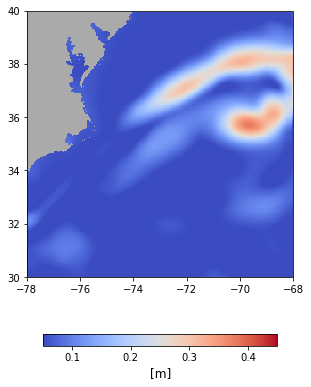

In [15]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())


im1 = ax1.pcolormesh(hycom25w.lon, hycom25w.lat,
                     filter_50km.apply(hycom25w.total_ssh.reset_coords(drop=True).astype(np.float64),
                                       dims=['Y', 'X']
                                      ).rolling(time=240, center=True
                                               ).mean().std('time',skipna=True).data,
                     vmin=.05, vmax=.45, cmap='coolwarm', rasterized=True
                    )
ax1.pcolormesh(hycom25w.lon, hycom25w.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.6)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM25-01-SSH10D-50kmstd_fma.pdf')

In [9]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########

    
gigatl01w = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='fma').to_dask()
                         ).chunk({'eta_rho':100,'xi_rho':100,'eta_v':100,'xi_u':100})
gigatl01s = adjust_coords(cat.GIGATL(region='1', datatype='surf', season='aso').to_dask()
                         ).chunk({'eta_rho':100,'xi_rho':100,'eta_v':100,'xi_u':100})
gigatl01w

<xarray.Dataset>
Dimensions:     (eta_rho: 1489, eta_v: 1488, time: 2280, xi_rho: 1491, xi_u: 1490)
Coordinates:
    lat         (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon         (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
Data variables:
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    salt        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    temp        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    u           (time, eta_rho, xi_u) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    v           (time, eta_v, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 100, 100), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (not periodic, boundary=None):\n  * cent...

In [10]:
grid = gigatl01w.attrs['xgcm-Grid']
grid

<xgcm.Grid>
xi Axis (not periodic, boundary=None):
  * center   xi_rho --> inner
  * inner    xi_u --> center
eta Axis (not periodic, boundary=None):
  * center   eta_rho --> inner
  * inner    eta_v --> center
s Axis (not periodic, boundary=None):
  * center   s_rho --> outer
  * outer    s_w --> center

In [11]:
mask = np.ma.masked_greater(gigatl01w.salt.isel(time=0),0.).mask

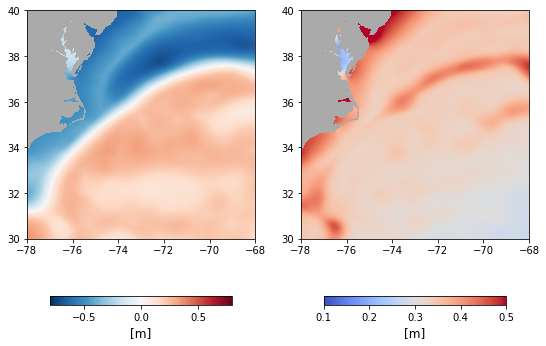

In [13]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(gigatl01w.lon, gigatl01w.lat,
                     gigatl01w.zeta.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(gigatl01w.lon, gigatl01w.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(gigatl01w.lon, gigatl01w.lat,
                     gigatl01w.zeta.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(gigatl01w.lon, gigatl01w.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/GIGA01-SSHmean_fma.pdf')

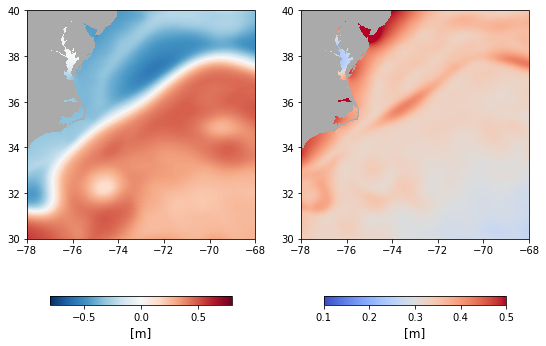

In [12]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(gigatl01s.lon, gigatl01s.lat,
                     gigatl01s.zeta.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(gigatl01s.lon, gigatl01s.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(gigatl01s.lon, gigatl01s.lat,
                     gigatl01s.zeta.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(gigatl01s.lon, gigatl01s.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/GIGA01-SSHmean_aso.pdf')

<string>:11: UserWarning: You have set n_steps below the default. Results might not be accurate.


Filter(filter_scale=50000.0, dx_min=array(921.05191062), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=50, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

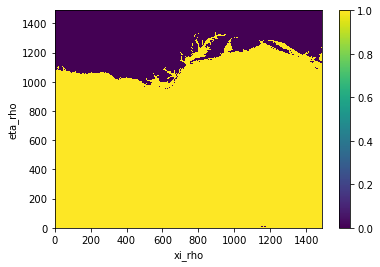

In [16]:
mask = np.ma.masked_invalid(np.ma.masked_greater(gigatl01w.salt.isel(time=0),0.)).mask

pad = 1
xrmask = xr.DataArray(mask.astype(np.float64), dims=gigatl01w.salt.isel(time=0).dims,
                      coords=gigatl01w.salt.isel(time=0).coords
                     )
mask[:2,:] = 0.
mask[-2:,:] = 0.
mask[:,:2] = 0.
mask[:,-2:] = 0.
xrmask.plot()
wet_mask = xr.DataArray(mask.astype(np.float64), dims=gigatl01w.salt.isel(time=0).dims,
                        coords=gigatl01w.salt.isel(time=0).coords
                       )

area = (gigatl01w.pm.astype(np.float64)**-1 * gigatl01w.pn.astype(np.float64)**-1)

dxw = xr.DataArray(grid.interp(gigatl01w.pm.astype(np.float64)**-1,
                               'xi').isel(eta_rho=slice(None,-1)).data,  # x-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'], 
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  )
dxw[:,:] = np.nan_to_num(dxw[:,:],nan=1)

dyw = xr.DataArray(grid.interp(gigatl01w.pn.astype(np.float64)**-1,
                               'xi').isel(eta_rho=slice(None,-1)).data,  # y-spacing centered at western cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  )
dyw[:,:] = np.nan_to_num(dyw[:,:],nan=1)

dxs = xr.DataArray(grid.interp(gigatl01w.pm.astype(np.float64)**-1,
                               'eta').isel(xi_rho=slice(None,-1)).data,  # x-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  ) 
dxs[:,:] = np.nan_to_num(dxs[:,:],nan=1)

dys = xr.DataArray(grid.interp(gigatl01w.pn.astype(np.float64)**-1,
                               'eta').isel(xi_rho=slice(None,-1)).data,  # y-spacing centered at southern cell edge
                   dims=['eta_rho','xi_rho'],
                   coords=wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)).coords
                  ) 
dys[:,:] = np.nan_to_num(dys[:,:],nan=1)


dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values

kappa_w = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1)))
kappa_s = xr.ones_like(wet_mask.isel(eta_rho=slice(None,-1),xi_rho=slice(None,-1))) 

filter_50km = gcm_filters.Filter(
    filter_scale=50e3,   # 50 km
    dx_min=dx_min,
    n_steps=50,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.isel(eta_rho=slice(None,-1),
                                  xi_rho=slice(None,-1)
                                 ).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxw': dxw.chunk({'eta_rho':-1,'xi_rho':-1}), 'dyw': dyw.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'dxs': dxs.chunk({'eta_rho':-1,'xi_rho':-1}), 'dys': dys.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'area': area.isel(eta_rho=slice(None,-1),
                          xi_rho=slice(None,-1)).chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_w': kappa_w.chunk({'eta_rho':-1,'xi_rho':-1}), 
        'kappa_s': kappa_s.chunk({'eta_rho':-1,'xi_rho':-1})
    }
)
filter_50km

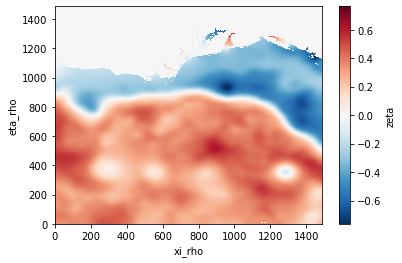

0
40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000
1040
1080
1120
1160
1200
1240
1280
1320
1360
1400
1440
1480
1520
1560
1600
1640
1680
1720
1760
1800
1840
1880
1920
1960
2000
2040
2080
2120
2160
2200
2240


<xarray.DataArray 'zeta' (time: 2280, eta_rho: 1488, xi_rho: 1490)>
array([[[ 0.35216632,  0.35135242,  0.35059416, ...,  0.27561137,
          0.27835035,  0.2807034 ],
        [ 0.35241586,  0.35156932,  0.35077438, ...,  0.27385518,
          0.27654675,  0.27888885],
        [ 0.35273388,  0.3518469 ,  0.3528625 , ...,  0.2315078 ,
          0.23164149,  0.27730435],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.2301215 ,  0.23000656,  0.22981244, ...,  0.1324367 ,
          0.1344503 ,  0.13633625],
        [ 0.23009066,  0.22992167,  0.22971945, ...,  0.13088664,
          0.13315596,  0.13506173],
        [ 0.23007508,  0.22984095,  0.22997089, ...,  0.08567749,
          0.08580363,  0.13382114],
...
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.16546932,  0.16464172,  0.16383886, ...,  0.08971225,
          0.09107716,  0.09254817],
        [ 0.16383481,  0.16293333,  0.1620478 , ...,  0.08977146,
          0.0910749 ,  0.09259841],
        [ 0.1620334 ,  0.16105023,  0.13398042, ...,  0.07348356,
          0.0735632 ,  0.09267329],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)
Dimensions without coordinates: time, eta_rho, xi_rho

In [17]:
zeta_filtered = xr.ones_like(gigatl01w.zeta.reset_coords(drop=True).isel(eta_rho=slice(None,-1),
                                                                         xi_rho=slice(None,-1)
                                                                        )
                            ).load() * np.nan
dtt = 40
for tt in range(0,len(gigatl01w.time),dtt):
    zeta_filtered[tt:tt+dtt] = filter_50km.apply(gigatl01w.zeta.reset_coords(drop=True
                                                                            ).isel(time=slice(tt,tt+dtt),
                                                                                   eta_rho=slice(None,-1),
                                                                                   xi_rho=slice(None,-1)
                                                                                  ).chunk({'eta_rho':-1,
                                                                                           'xi_rho':-1}
                                                                                         ).astype(np.float64),
                                                 dims=['eta_rho', 'xi_rho']
                                                ).compute().chunk({'eta_rho':200,'xi_rho':200})
    if tt == 0:
        zeta_filtered.isel(time=0).plot()
        plt.show()
    print(tt)
zeta_filtered

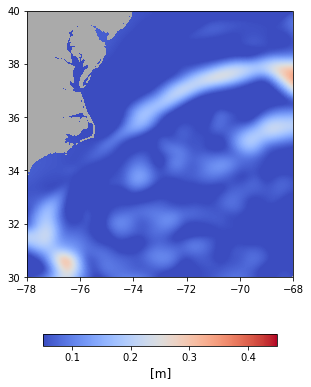

In [19]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(gigatl01w.lon, gigatl01w.lat,
#                      gigatl01w.zeta.std('time',skipna=True).data,
                     zeta_filtered.chunk({'eta_rho':100,'xi_rho':100}
                                        ).rolling(time=240, center=True
                                                 ).mean().std('time',skipna=True).data,
                     vmin=.05, vmax=.45, cmap='coolwarm', rasterized=True
                    )
ax1.pcolormesh(gigatl01w.lon, gigatl01w.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.6)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/GIGA01-SSH10D-50kmstd_fma.pdf')

In [6]:
fesom01w = cat.FESOM(datatype='surf', season='fma').to_dask().chunk({'lat':200,'lon':200})
fesom01s = cat.FESOM(datatype='surf', season='aso').to_dask().chunk({'lat':200,'lon':200})
fesom01w

,Array,Chunk
Bytes,16.09 GiB,3.05 MiB
Shape,"(2160, 1000, 1000)","(10, 200, 200)"
Count,11017 Tasks,5400 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,16.09 GiB,3.05 MiB
Shape,"(2160, 1000, 1000)","(10, 200, 200)"
Count,11017 Tasks,5400 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [7]:
mask = xr.DataArray(np.ma.masked_invalid(fesom01s.sss.where(fesom01s.sss>32.).where(fesom01s.sss<38.)
                                        ).mask,
                    dims=fesom01s.sss.dims, coords=fesom01s.sss.coords
                   ).chunk({'lat':200,'lon':200}).mean('time',skipna=True)
mask = xr.DataArray(np.ma.masked_invalid(mask.where(mask==1.)).mask,
                    dims=fesom01s.sss.isel(time=0).dims, 
                    coords=fesom01s.sss.isel(time=0).coords
                   )

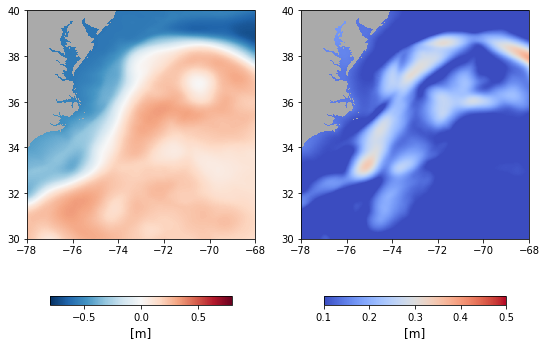

In [13]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(fesom01w.lon, fesom01w.lat,
                     fesom01w.ssh.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(fesom01w.lon, fesom01w.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(fesom01w.lon, fesom01w.lat,
                     fesom01w.ssh.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(fesom01w.lon, fesom01w.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FESOM01-SSHmean_fma.pdf')

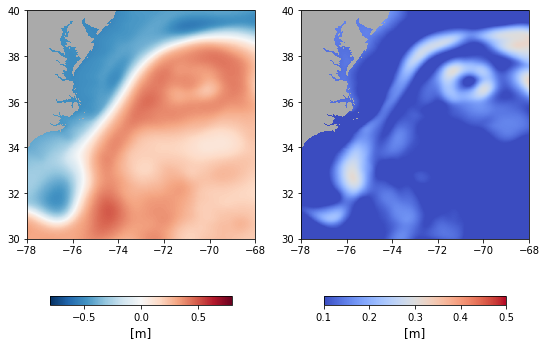

In [15]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(fesom01s.lon, fesom01s.lat,
                     fesom01s.ssh.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolormesh(fesom01s.lon, fesom01s.lat, 
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(fesom01s.lon, fesom01s.lat,
                     fesom01s.ssh.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolormesh(fesom01s.lon, fesom01s.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FESOM01-SSHmean_aso.pdf')

In [8]:
wet_mask = xr.DataArray(np.zeros_like(fesom01w.sss),
                        dims=['time','lat','lon'],
                        coords={'time':fesom01w.time.data,
                                'lat':fesom01w.lat.data,
                                'lon':fesom01w.lon.data}
           )
wet_mask[:,1:-1,1:-1] = (~np.ma.masked_invalid(fesom01w.sss.where(fesom01w.sss>32.).where(fesom01w.sss<38.).isel(lat=slice(1,-1),
                                                                                                                 lon=slice(1,-1))
                                              ).mask).astype(np.float64)

import gsw
xx, yy = np.meshgrid(fesom01w.lon, fesom01w.lat
                    )
ny, nx = xx.shape
dx = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                               coords={'lat':np.arange(ny),'lon':np.arange(.5,nx-1,1)}
                              ).interp(lon=np.arange(nx), method="linear",
                                       kwargs={"fill_value": "extrapolate"}).data,
                  dims=['lat','lon'], 
                  coords={'lat':fesom01w.lat.data,'lon':fesom01w.lon.data}
                 )
dy = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                               coords={'lat':np.arange(.5,ny-1,1),'lon':np.arange(nx)}
                              ).interp(lat=np.arange(ny), method="linear",
                                       kwargs={"fill_value": "extrapolate"}).data,
                  dims=['lat','lon'], 
                  coords={'lat':fesom01w.lat.data,'lon':fesom01w.lon.data}
                 )

area = (dx * dy)

dlat = fesom01w.lat.diff('lat')[0]
dlon = fesom01w.lon.diff('lon')[0]

dxw = xr.DataArray(dx.interp(lon=np.arange(dx.lon.min()-dlon,dx.lon.max()-dlon,dlon),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dx.dims, coords=dx.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dy.interp(lon=np.arange(dy.lon.min()-dlon,dy.lon.max()-dlon,dlon),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dy.dims, coords=dy.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dx.interp(lat=np.arange(dx.lat.min()-dlat,dx.lat.max()-dlat,dlat),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dx.dims, coords=dx.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dy.interp(lat=np.arange(dy.lat.min()-dlat,dy.lat.max()-dlat,dlat),
                             method='linear',
                             kwargs={"fill_value": "extrapolate"}).data,
                   dims=dy.dims, coords=dy.coords
                  ) # y-spacing centered at southern cell edge

dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values

kappa_w = xr.ones_like(wet_mask.isel(time=0))
kappa_s = xr.ones_like(wet_mask.isel(time=0))

filter_scale = 50e3   # 50 km

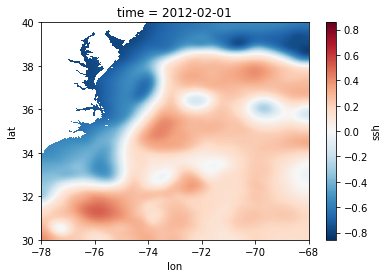

0
40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000
1040
1080
1120
1160
1200
1240
1280
1320
1360
1400
1440
1480
1520
1560
1600
1640
1680
1720
1760
1800
1840
1880
1920
1960
2000
2040
2080
2120


<xarray.DataArray 'ssh' (time: 2160, lat: 1000, lon: 1000)>
array([[[ 0.4333274 ,  0.43326301,  0.43303325, ...,  0.17602532,
          0.17680229,  0.17776368],
        [ 0.43401421,  0.39569834,  0.39555202, ...,  0.16261472,
          0.16264578,  0.17712768],
        [ 0.43436969,  0.39557313,  0.39542614, ...,  0.16258347,
          0.16261449,  0.17663795],
        ...,
        [        nan,         nan,         nan, ..., -0.61947708,
         -0.61949804, -0.59917269],
        [        nan,         nan,         nan, ..., -0.61929009,
         -0.61931148, -0.59648056],
        [        nan,         nan,         nan, ..., -0.59256741,
         -0.59315778, -0.59362752]],

       [[ 0.43650965,  0.43625582,  0.43581219, ...,  0.17576554,
          0.1765412 ,  0.17753665],
        [ 0.4369237 ,  0.39824928,  0.39810185, ...,  0.16310402,
          0.16313552,  0.17672388],
        [ 0.43702533,  0.39812736,  0.39797935, ...,  0.1630741 ,
          0.16310534,  0.17611392],
...
        [        nan,         nan,         nan, ..., -0.61830375,
         -0.61833668, -0.60416072],
        [        nan,         nan,         nan, ..., -0.61814509,
         -0.61817774, -0.60201541],
        [        nan,         nan,         nan, ..., -0.59830245,
         -0.59905276, -0.59974955]],

       [[ 0.16429396,  0.16390382,  0.1636596 , ...,  0.13683455,
          0.13650215,  0.13622435],
        [ 0.16308837,  0.1389905 ,  0.13892033, ...,  0.15582529,
          0.1557732 ,  0.13692884],
        [ 0.16230496,  0.13882642,  0.13875593, ...,  0.15588281,
          0.15583068,  0.13754888],
        ...,
        [        nan,         nan,         nan, ..., -0.61845152,
         -0.61848599, -0.60419679],
        [        nan,         nan,         nan, ..., -0.61829401,
         -0.61832797, -0.60200391],
        [        nan,         nan,         nan, ..., -0.59826831,
         -0.5990624 , -0.59977707]]])
Coordinates:
  * lat      (lat) float64 30.0 30.01 30.02 30.03 ... 39.97 39.98 39.99 40.0
  * lon      (lon) float64 -78.0 -77.99 -77.98 -77.97 ... -68.02 -68.01 -68.0
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00

In [9]:
ssh_filtered = xr.ones_like(fesom01w.ssh.reset_coords(drop=True)).load() * np.nan

dtt = 40
for tt in range(0,len(fesom01w.time),dtt):
    filter_50km = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': wet_mask.isel(time=slice(tt,tt+dtt)).chunk({'lat':-1,'lon':-1}), 
            'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
            'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
            'area': area.chunk({'lat':-1,'lon':-1}), 
            'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
        }
    )
    ssh_filtered[tt:tt+dtt] = filter_50km.apply(fesom01w.ssh.reset_coords(drop=True
                                                                         ).isel(time=slice(tt,tt+dtt)
                                                                               ).chunk({'lat':-1,
                                                                                        'lon':-1}
                                                                                      ).astype(np.float64),
                                                dims=['lat', 'lon']
                                               ).compute().chunk({'lat':200,'lon':200})
    if tt == 0:
        ssh_filtered.isel(time=0).plot()
        plt.show()
    print(tt)
    
ssh_filtered

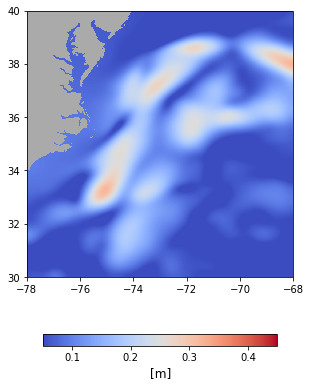

In [10]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(fesom01w.lon, fesom01w.lat,
#                      fesom01w.ssh.std('time',skipna=True).data,
                     ssh_filtered.rolling(time=240, center=True
                                         ).mean().std('time',skipna=True).data,
                     vmin=.05, vmax=.45, cmap='coolwarm', rasterized=True
                    )
ax1.pcolormesh(fesom01w.lon, fesom01w.lat,
               np.ma.masked_array(mask,mask).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.6)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FESOM01-SSH10D-50kmstd_fma.pdf')

In [6]:
orca01w = cat.ORCA36(region='1',datatype='surface_hourly', season='fma').to_dask().isel(y=slice(None,450))
orca01s = cat.ORCA36(region='1',datatype='surface_hourly', season='aso').to_dask().isel(y=slice(None,450))
orca01w

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 2090, x: 361, y: 450)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(450, 361), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2014-02-01T00:30:00 ....
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    sossheig              (time_counter, y, x) float32 dask.array<chunksize=(72, 450, 361), meta=np.ndarray>
    ssh_ib                (time_counter, y, x) float32 dask.array<chunksize=(72, 450, 361), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(72, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(72, 2), meta=np.ndarray>
    tos                   (time_counter, y, x) float32 dask.array<chunksize=(72, 450, 361), meta=np.ndarray>
    uos                   (time_counter, y, x) float32 dask.array<chunksize=(72, 450, 361), meta=np.ndarray>
    vos                   (time_counter, y, x) float32 dask.array<chunksize=(72, 450, 361), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    NCO:                       "4.6.2"
    description:               ocean T grid variables
    history:                   Wed Jun 23 12:32:16 2021: ncrcat -O /scratch/w...
    nco_openmp_thread_number:  1
    title:                     ocean T grid variables
    uuid:                      35febf29-246a-4bdc-b474-8886d4868069

In [7]:
orca01_grid = cat.ORCA36(region='1',datatype='grid',grid='meshmask').to_dask().isel(time_counter=0,y=slice(None,450))
orca01_grid

<xarray.Dataset>
Dimensions:       (nav_lev: 75, x: 361, y: 450)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_counter  float64 0.0
Dimensions without coordinates: x, y
Data variables: (12/50)
    e1f           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1u           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e1v           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e2f           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    e2t           (y, x) float64 dask.array<chunksize=(450, 361), meta=np.ndarray>
    ...            ...
    tmask         (nav_lev, y, x) int8 dask.array<chunksize=(75, 450, 361), meta=np.ndarray>
    tmaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
    umask         (nav_lev, y, x) int8 dask.array<chunksize=(75, 450, 361), meta=np.ndarray>
    umaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
    vmask         (nav_lev, y, x) int8 dask.array<chunksize=(75, 450, 361), meta=np.ndarray>
    vmaskutil     (y, x) int8 dask.array<chunksize=(450, 361), meta=np.ndarray>
Attributes:
    NCO:        "4.6.2"
    TimeStamp:  11/02/2021 04:31:39 -0000
    file_name:  mesh_mask.nc
    history:    Mon Jun 21 12:11:40 2021: ncks -O -F -d x,7526,7886 -d y,5884...

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: Matp

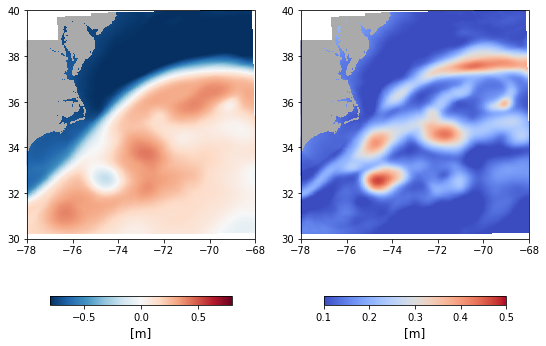

In [10]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.), orca01w.nav_lat.where(orca01w.nav_lat>0.),
                     orca01w.sossheig.mean('time_counter',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )
ax1.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.), orca01w.nav_lat.where(orca01w.nav_lat>0.),
               np.ma.masked_values(orca01_grid.tmask.isel(nav_lev=0), 
                                   1.).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

im2 = ax2.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.), orca01w.nav_lat.where(orca01w.nav_lat>0.),
                     orca01w.sossheig.std('time_counter',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )
ax2.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.), orca01w.nav_lat.where(orca01w.nav_lat>0.),
               np.ma.masked_values(orca01_grid.tmask.isel(nav_lev=0), 
                                   1.).astype(np.float64),
               vmin=-1, vmax=2, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/ORCA01-SSHmean_fma.pdf')

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: Matp

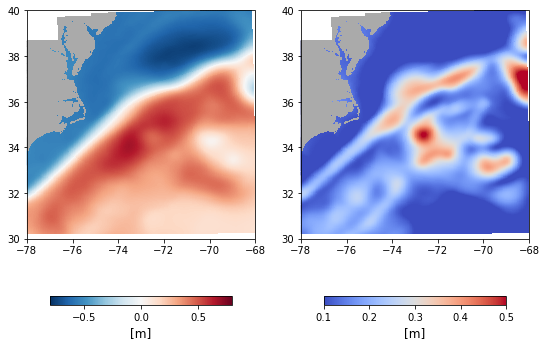

In [18]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolor(orca01s.nav_lon.where(orca01s.nav_lon<-40.), orca01s.nav_lat.where(orca01s.nav_lat>0.),
                 orca01s.sossheig.mean('time_counter',skipna=True).data,
                 vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                )
ax1.pcolor(orca01s.nav_lon.where(orca01s.nav_lon<-40.), orca01s.nav_lat.where(orca01s.nav_lat>0.),
           np.ma.masked_values(orca01_grid.tmask.isel(nav_lev=0), 
                               1.).astype(np.float64),
           vmin=-1, vmax=2, cmap='binary', rasterized=True
          )

im2 = ax2.pcolor(orca01s.nav_lon.where(orca01s.nav_lon<-40.), orca01s.nav_lat.where(orca01s.nav_lat>0.),
                 orca01s.sossheig.std('time_counter',skipna=True).data,
                 vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                )
ax2.pcolor(orca01s.nav_lon.where(orca01s.nav_lon<-40.), orca01s.nav_lat.where(orca01s.nav_lat>0.),
           np.ma.masked_values(orca01_grid.tmask.isel(nav_lev=0), 
                               1.).astype(np.float64),
           vmin=-1, vmax=2, cmap='binary', rasterized=True
          )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/ORCA01-SSHmean_aso.pdf')

In [47]:
wet_mask = xr.DataArray(np.zeros_like(orca01w.tos.isel(time_counter=0)),
                        dims=['y','x'],
#                         coords={'y':np.arange(len(orca01w.y)),
#                                 'x':np.arange(len(orca01w.x))}
           )
wet_mask[1:-1,1:-1] = orca01_grid.tmask[0,1:-1,1:-1].data.astype(np.float64)

area = (orca01_grid.e1t * orca01_grid.e2t)

dxw = xr.DataArray(orca01_grid.e1u.data, dims=['y','x'],
#                    coords={'y':np.arange(len(orca01w.y)),
#                            'x':np.arange(len(orca01w.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(orca01_grid.e2u.data, dims=['y','x'],
#                    coords={'y':np.arange(len(orca01w.y)),
#                            'x':np.arange(len(orca01w.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(orca01_grid.e1v.data, dims=['y','x'],
#                    coords={'y':np.arange(len(orca01w.y)),
#                            'x':np.arange(len(orca01w.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(orca01_grid.e2v.data, dims=['y','x'],
#                    coords={'y':np.arange(len(orca01w.y)),
#                            'x':np.arange(len(orca01w.x))}
                  ) # y-spacing centered at southern cell edge

dx_min = min(orca01_grid.e1u.where(orca01_grid.e1u>0.).min(['y','x'],skipna=True), 
             orca01_grid.e2u.where(orca01_grid.e2u>0.).min(['y','x'],skipna=True),
             orca01_grid.e1v.where(orca01_grid.e1v>0.).min(['y','x'],skipna=True), 
             orca01_grid.e2v.where(orca01_grid.e2v>0.).min(['y','x'],skipna=True)
            )
dx_min = dx_min.values

kappa_w = xr.zeros_like(wet_mask)
kappa_w[1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[1:-1,1:-1] += 1.

filter_scale = 50e3
filter_50km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


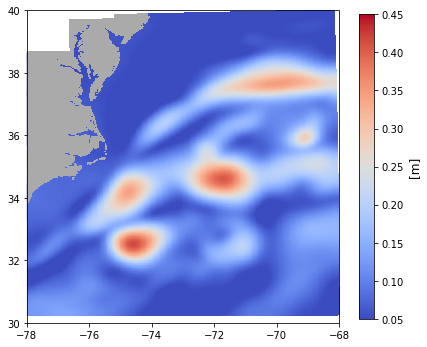

In [48]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())


im1 = ax1.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.), orca01w.nav_lat.where(orca01w.nav_lat>0.),
#                  orca01w.sossheig.std('time_counter',skipna=True).data,
                 filter_50km.apply(orca01w.sossheig.reset_coords(drop=True
                                                                ).chunk({'y':-1,'x':-1}
                                                                       ).astype(np.float64),
                                   dims=['y', 'x']
                                  ).rolling(time_counter=240, center=True
                                           ).mean().std('time_counter',skipna=True).data,
                 vmin=.05, vmax=.45, cmap='coolwarm', rasterized=True
                )
ax1.pcolor(orca01w.nav_lon.where(orca01w.nav_lon<-40.), orca01w.nav_lat.where(orca01w.nav_lat>0.),
           np.ma.masked_values(orca01_grid.tmask.isel(nav_lev=0), 
                               1.).astype(np.float64),
           vmin=-1, vmax=2, cmap='binary', rasterized=True
           )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/ORCA01-SSH10D-50kmstd_fma.pdf')

In [22]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC4320Model()
print(model.varnames)

istart = 497664
di = 144
iters = np.arange(istart,int(istart+(29+31+30)*24*di),di)
# nl = 14
nlt = 1

ds = model.get_dataset(varnames=['Eta'], k_levels=[0], 
                       iters=[iters[0]],
                       type='latlon',
            #                                               grid_vars_to_coords=False
                      ).isel(j=list(np.arange(9555,10198)),
                             j_g=list(np.arange(9555,10198)),
                             i=list(np.arange(15355,15845)),
                             i_g=list(np.arange(15355,15845)),
                             k=0, k_l=0
                            )


Etaw = xr.DataArray(np.ones((len(iters),len(np.arange(9555,10198)),
                             len(np.arange(15355,15845))))*np.nan,
                    dims=['time','j','i'],
                    coords={'time':np.arange(len(iters))*3600}
                   )

dil = 10
for il in np.arange(len(iters))[::dil]:
    Etaw.isel(time=slice(il,il+dil))[:] = model.get_dataset(varnames=['Eta'], k_levels=[0], 
                                                            iters=list(iters[il:il+dil]),
                                                            type='latlon',
            #                                               grid_vars_to_coords=False
                                                           ).isel(j=list(np.arange(9555,10198)),
                                                                  j_g=list(np.arange(9555,10198)),
                                                                  i=list(np.arange(15355,15845)),
                                                                  i_g=list(np.arange(15355,15845)),
                                                                  k=0, k_l=0
                                                                 ).Eta.reset_coords(drop=True).load().data
    if il % 30 == 0:
        print(il, iters[il])
    
Etaw = Etaw.chunk({'j':100,'i':100})
Etaw

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']
0 497664
30 501984
60 506304
90 510624
120 514944
150 519264
180 523584
210 527904
240 532224
270 536544
300 540864
330 545184
360 549504
390 553824
420 558144
450 562464
480 566784
510 571104
540 575424
570 579744
600 584064
630 588384
660 592704
690 597024
720 601344
750 605664
780 609984
810 614304
840 618624
870 622944
900 627264
930 631584
960 635904
990 640224
1020 644544
1050 648864
1080 653184
1110 657504
1140 661824
1170 666144
1200 670464
1230 674784
1260 679104
1290 683424
1320 687744
1350 692064
1380 696384
1410 700704
1440 705024
1470 709344
1500 713664
1530 717984
1560 722304
1590 726624
1620 730944
1650 735264
1680 739584
1710 743904
1740 748224
1770 752544
1800 756864
1830 761184
1860 765504
1890 769824
1920 774144
1950 778464
1980 782784
2010 787104
2040 791424
2070 795744
2100 80006

<xarray.DataArray (time: 2160, j: 643, i: 490)>
dask.array<xarray-<this-array>, shape=(2160, 643, 490), dtype=float64, chunksize=(2160, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 7761600 7765200 7768800 7772400
Dimensions without coordinates: j, i

In [36]:
Etaw.coords['j'] = ('j', ds.j.data)
Etaw.coords['i'] = ('i', ds.i.data)

In [6]:
mask = xr.DataArray(np.ma.masked_invalid(Etaw.isel(time=0)).mask,
                    dims=Etaw.isel(time=0).dims, coords=Etaw.isel(time=0).coords
                   )
mask = xr.DataArray(np.ma.masked_invalid(mask.where(mask==1.)).mask,
                    dims=Etaw.isel(time=0).dims, coords=Etaw.isel(time=0).coords
                   ).reset_coords(drop=True).chunk({'j':100,'i':100})

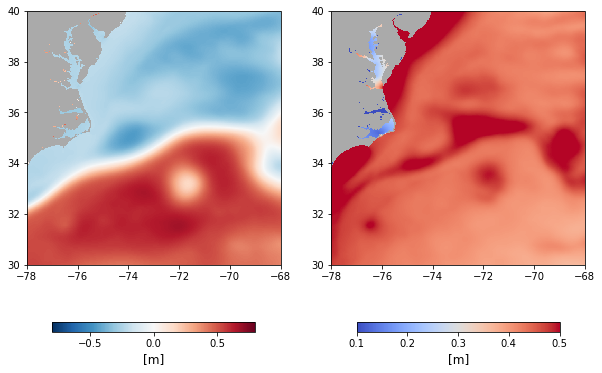

In [7]:
fig = plt.figure(figsize=(10,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(ds.XC, ds.YC,
                     Etaw.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', shading='auto', rasterized=True
                    )
ax1.pcolormesh(ds.XC, ds.YC,
               np.ma.masked_array(mask,mask).astype(np.float32),
               vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True 
              )

im2 = ax2.pcolormesh(ds.XC, ds.YC,
                     Etaw.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', shading='auto', rasterized=True
                    )
ax2.pcolormesh(ds.XC, ds.YC,
               np.ma.masked_array(mask,mask).astype(np.float32),
               vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True 
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/LLC01-SSHmean_fma.pdf')

In [41]:
pad = 1
mask = ~np.ma.masked_invalid(Etaw.isel(time=0)).mask
xrmask = xr.DataArray(mask.astype(np.float64), dims=Etaw.isel(time=0).dims,
                      coords=Etaw.isel(time=0).coords
                     )
mask[:1,:] = 0.
mask[-1:,:] = 0.
mask[:,:1] = 0.
mask[:,-1:] = 0.
wet_mask = xr.DataArray(mask.astype(np.float64), dims=Etaw.isel(time=0).dims,
                        coords=Etaw.isel(time=0).coords
                       )

area = xr.DataArray(ds.dyF * ds.dxF, dims=['j','i'],
                    coords=Etaw.isel(time=0).coords
                   ).astype(np.float64).load()

dxw = xr.DataArray(ds.dxC.data.astype(np.float64),  # x-spacing centered at western cell edge
                   dims=['j','i'], 
                   coords=Etaw.isel(time=0).coords
                  ).load()

dyw = xr.DataArray(ds.dyG.data.astype(np.float64),  # y-spacing centered at western cell edge
                   dims=['j','i'],
                   coords=Etaw.isel(time=0).coords
                  ).load()

dxs = xr.DataArray(ds.dxG.data.astype(np.float64),  # x-spacing centered at southern cell edge
                   dims=['j','i'],
                   coords=Etaw.isel(time=0).coords
                  ).load()

dys = xr.DataArray(ds.dyC.data.astype(np.float64),  # y-spacing centered at southern cell edge
                   dims=['j','i'],
                   coords=Etaw.isel(time=0).coords
                  ).load()

dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values


kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask) 

filter_50km = gcm_filters.Filter(
    filter_scale=50e3,   # 30 km
    dx_min=dx_min,
#     n_steps=50,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'j':-1,'i':-1}), 
        'dxw': dxw.chunk({'j':-1,'i':-1}), 'dyw': dyw.chunk({'j':-1,'i':-1}), 
        'dxs': dxs.chunk({'j':-1,'i':-1}), 'dys': dys.chunk({'j':-1,'i':-1}), 
        'area': area.chunk({'j':-1,'i':-1}), 
        'kappa_w': kappa_w.chunk({'j':-1,'i':-1}), 
        'kappa_s': kappa_s.chunk({'j':-1,'i':-1})
    }
)

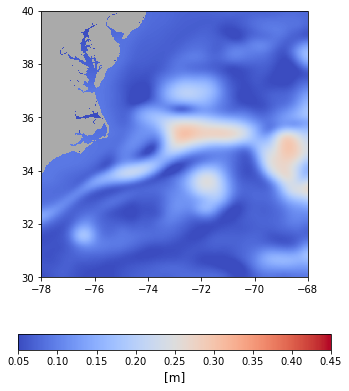

In [45]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())


im1 = ax1.pcolormesh(ds.XC, ds.YC,
#                      Etaw.std('time',skipna=True).data,
                     filter_50km.apply(Etaw.chunk({'time':40,'j':-1,'i':-1}
                                                 ).astype(np.float64),
                                       dims=['j', 'i']
                                      ).chunk({'j':100,'i':100}).rolling(time=240, center=True
                                                                        ).mean().std('time',skipna=True).data,
                     vmin=.05, vmax=.45, cmap='coolwarm', shading='auto', rasterized=True
                    )
ax1.pcolormesh(ds.XC, ds.YC,
               np.ma.masked_array(mask,mask).astype(np.float32),
               vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True 
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/LLC01-SSH10D-50kmstd_fma.pdf')

In [7]:
fio01w = cat['FIO-COM32'](region='1',datatype='surface_hourly', season='fma'
                      ).to_dask()
fio01s = cat['FIO-COM32'](region='1',datatype='surface_hourly', season='aso'
                      ).to_dask()
fio01grid = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/grid.zarr"))
fio01w

<xarray.Dataset>
Dimensions:       (time: 2136, xt_ocean: 320, xu_ocean: 321, yt_ocean: 320, yu_ocean: 321)
Coordinates:
  * time          (time) datetime64[ns] 2018-02-01T13:00:00 ... 2018-05-01T12...
  * xt_ocean      (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.05 -68.02
  * xu_ocean      (xu_ocean) float64 -78.0 -77.97 -77.94 ... -68.06 -68.03 -68.0
  * yt_ocean      (yt_ocean) float64 30.02 30.05 30.08 ... 39.92 39.95 39.98
  * yu_ocean      (yu_ocean) float64 30.0 30.03 30.06 30.09 ... 39.94 39.97 40.0
Data variables:
    eta_t         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(275, 320, 320), meta=np.ndarray>
    surface_salt  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(275, 320, 320), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(275, 320, 320), meta=np.ndarray>
    usurf         (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(275, 321, 321), meta=np.ndarray>
    vsurf         (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(275, 321, 321), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

In [8]:
mask = np.ma.masked_invalid(fio01w.surface_temp.isel(time=0)).mask

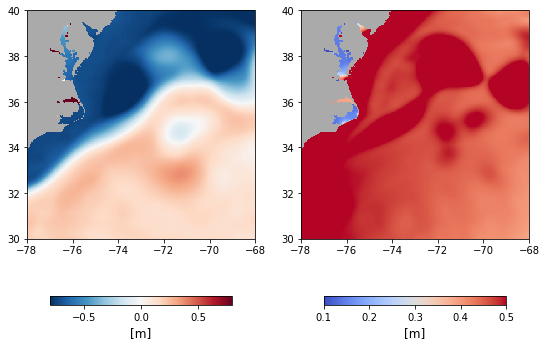

In [9]:
fig = plt.figure(figsize=(9,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax2.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax2.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
                     fio01w.eta_t.mean('time',skipna=True).data,
                     vmin=-.8, vmax=.8, cmap='RdBu_r', rasterized=True
                    )

ax1.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
               np.ma.masked_array(mask,~mask),
               vmin=0, vmax=3, cmap='binary', rasterized=True
              )

im2 = ax2.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
                     fio01w.eta_t.std('time',skipna=True).data,
                     vmin=.1, vmax=.5, cmap='coolwarm', rasterized=True
                    )

ax2.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
               np.ma.masked_array(mask,~mask),
               vmin=0, vmax=3, cmap='binary', rasterized=True
              )
cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.8)
cbar1.set_label(r"[m]", fontsize=12)
cbar2 = fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=.8)
cbar2.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FIOCOM01-SSHmean_fma.pdf')

In [18]:
wet_mask = xr.DataArray(np.zeros_like(fio01w.eta_t.isel(time=0)),
                        dims=['yt_ocean','xt_ocean'],
                        coords=fio01w.eta_t.isel(time=0).coords
           )
wet_mask[1:-1,1:-1] = mask[1:-1,1:-1].astype(np.float64)

area = xr.DataArray((fio01grid.DYT * fio01grid.DXT).data, dims=['yt_ocean','xt_ocean'],
                    coords=fio01w.eta_t.isel(time=0).coords
                   )

dxw = xr.DataArray(.5*(fio01grid.DXC[1:,:-1].data + fio01grid.DXC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(.5*(fio01grid.DYC[1:,:-1].data + fio01grid.DYC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(.5*(fio01grid.DXC[:-1,1:].data + fio01grid.DXC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(.5*(fio01grid.DYC[:-1,1:].data + fio01grid.DYC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  )

dx_min = min(fio01grid.DXT.min(['YT_OCEAN3585_3904','XT_OCEAN6465_6784'],skipna=True), 
             fio01grid.DYT.min(['YT_OCEAN3585_3904','XT_OCEAN6465_6784'],skipna=True),
             fio01grid.DXC[1:,1:].min(['YU_OCEAN3584_3904','XU_OCEAN6464_6784'],skipna=True), 
             fio01grid.DYC[1:,1:].min(['YU_OCEAN3584_3904','XU_OCEAN6464_6784'],skipna=True)
            )
dx_min = dx_min.values

kappa_w = xr.zeros_like(wet_mask)
kappa_w[1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[1:-1,1:-1] += 1.

filter_scale = 50e3
filter_50km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'dxw': dxw.chunk({'yt_ocean':-1,'xt_ocean':-1}), 'dyw': dyw.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'dxs': dxs.chunk({'yt_ocean':-1,'xt_ocean':-1}), 'dys': dys.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'area': area.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'kappa_w': kappa_w.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'kappa_s': kappa_s.chunk({'yt_ocean':-1,'xt_ocean':-1})
    }
)

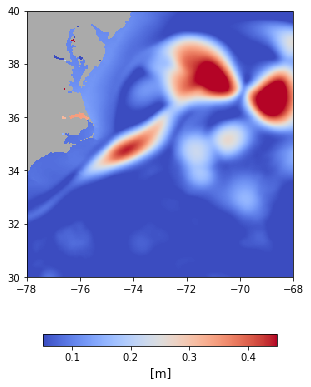

In [23]:
fig = plt.figure(figsize=(7,7))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-78,-68, 30, 40], crs=ccrs.PlateCarree())
ax1.set_xticks([-78,-76,-74,-72,-70,-68], crs=ccrs.PlateCarree())
ax1.set_yticks([30,32,34,36,38,40], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
                     filter_50km.apply(fio01w.eta_t.reset_coords(drop=True).astype(np.float64),
                                       dims=['yt_ocean', 'xt_ocean']
                                      ).rolling(time=240, center=True
                                               ).mean().std('time',skipna=True).data,
                     vmin=.05, vmax=.45, cmap='coolwarm', rasterized=True
                    )
ax1.pcolormesh(fio01w.xt_ocean, fio01w.yt_ocean,
               np.ma.masked_array(mask,~mask).astype(np.float64),
               vmin=0, vmax=3, cmap='binary', rasterized=True
              )

cbar1 = fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=.6)
cbar1.set_label(r"[m]", fontsize=12)

plt.savefig('/home/jovyan/Figures/FIOCOM01-SSH10D-50kmstd_fma.pdf')